In [1]:
import hyperparam_optimization as ho
import numpy as np
import math

from rerf.rerfClassifier import rerfClassifier
from sklearn.ensemble import RandomForestClassifier

import openml
from sklearn.model_selection import train_test_split
from sklearn import metrics

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# get some data
task_id = 146821 #car
openml.config.apikey = 'c9ea8896542dd998ea42685f14e2bc14'
benchmark_suite = openml.study.get_suite('OpenML-CC18')
task = openml.tasks.get_task(task_id)
X, y = task.get_X_and_y()
n_features = np.shape(X)[1]
n_samples = np.shape(X)[0]

# build a classifier
rerf = rerfClassifier()

#specify max_depth and min_sample_splits ranges
max_depth_array_rerf = (np.unique(np.round((np.linspace(2,n_samples,
                    10))))).astype(int)
max_depth_range_rerf = np.append(max_depth_array_rerf, None)

min_sample_splits_range_rerf = (np.unique(np.round((np.arange(1,math.log(n_samples),
                            (math.log(n_samples)-2)/10))))).astype(int)

# specify parameters and distributions to sample from
rerf_param_dict = {"n_estimators": np.arange(50,550,50),
              "max_depth": max_depth_range_rerf,
              "min_samples_split": min_sample_splits_range_rerf,
              "feature_combinations": [1,2,3,4,5], 
              "max_features": ["sqrt","log2", None, n_features**2]}

#build another classifier
rf = RandomForestClassifier()

#specify max_depth and min_sample_splits ranges
max_depth_array_rf = (np.unique(np.round((np.linspace(2,n_samples,
                    10))))).astype(int)
max_depth_range_rf = np.append(max_depth_array_rf, None)

min_sample_splits_range_rf = (np.unique(np.round((np.arange(2,math.log(n_samples),
                            (math.log(n_samples)-2)/10))))).astype(int)

# specify parameters and distributions to sample from
rf_param_dict = {"n_estimators": np.arange(50,550,50),
              "max_depth": max_depth_range_rf,
              "min_samples_split": min_sample_splits_range_rf, 
              "max_features": ["sqrt","log2", None]}

In [3]:
#get best parameters dictionary
best_params = ho.hyperparameter_optimization_random(X, y, 
                                        (rerf, rerf_param_dict), (rf, rf_param_dict))
print(best_params)

{rerfClassifier(feature_combinations=1.5, image_height=None, image_width=None,
               max_depth=None, max_features='auto', min_samples_split=1,
               n_estimators=500, n_jobs=None, oob_score=False,
               patch_height_max=None, patch_height_min=1, patch_width_max=None,
               patch_width_min=1, projection_matrix='RerF', random_state=None): {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 36, 'max_depth': 577, 'feature_combinations': 3}, RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False): {'n_estimators': 3

In [4]:
#extract values from dict - seperate each classifier's param dict
keys, values = zip(*best_params.items())
    
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#get accuracies of optimized and default models
rerf_opti = rerfClassifier(**values[0])
rerf_opti.fit(X_train, y_train)
rerf_pred_opti = rerf_opti.predict(X_test)
rerf_acc_opti = metrics.accuracy_score(y_test, rerf_pred_opti)
    
rerf_default = rerfClassifier()
rerf_default.fit(X_train, y_train)
rerf_pred_default = rerf_default.predict(X_test)
rerf_acc_default = metrics.accuracy_score(y_test, rerf_pred_default)

rf_opti = RandomForestClassifier(**values[1])
rf_opti.fit(X_train, y_train)
rf_pred_opti = rf_opti.predict(X_test)
rf_acc_opti = metrics.accuracy_score(y_test, rf_pred_opti)
    
rf_default = RandomForestClassifier()
rf_default.fit(X_train, y_train)
rf_pred_default = rf_default.predict(X_test)
rf_acc_default = metrics.accuracy_score(y_test, rf_pred_default)

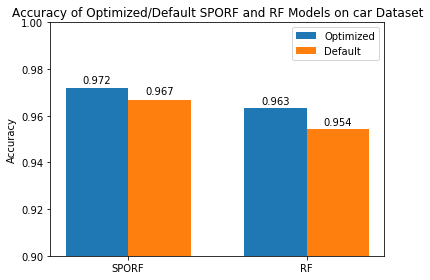

In [17]:
#plot accuracies

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['SPORF', 'RF']
rerf_acc = [rerf_acc_opti, rerf_acc_default]
rf_acc = [rf_acc_opti, rf_acc_default]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rerf_acc, width, label='Optimized')
rects2 = ax.bar(x + width/2, rf_acc, width, label='Default')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Optimized/Default SPORF and RF Models on car Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = float('%.3f'%(rect.get_height()))
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.ylim((.9, 1))
plt.show()